In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.basics import *

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [2]:
path = Config().data_path()/'mnist'

In [3]:
path.ls()

[PosixPath('/home/user/.fastai/data/mnist/mnist.pkl.gz')]

In [4]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1') #pickle(binary)파일 open.

(50000, 784)

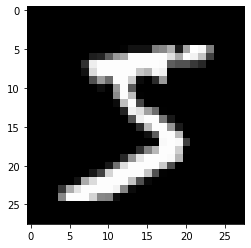

In [5]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape # training 50000장, 784차원 이미지. ( 28 * 28)

In [6]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid)) # torch.tensor로 data type변경.
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [7]:
bs=64 # batch size = 64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs) # train set, validation set을 학습을 위해 Databunch

In [8]:
x,y = next(iter(data.train_dl)) # iterator. 하나의 iteration은 하나의 mini-batch를 얘기함.
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [9]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb): return self.lin(xb)

In [10]:
model = Mnist_Logistic().cuda() # Mnist_Logistic object를 cuda를 사용할 수 있게 세팅. (GPU를 사용하려는 목적.)

In [11]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [12]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [13]:
model(x).shape

torch.Size([64, 10])

In [14]:
[p.shape for p in model.parameters()] # 784차원 Linear model에서 사용하는 parameter. Logistic regression에서, 10*784와, 1*10이 있다.

[torch.Size([10, 784]), torch.Size([10])]

In [15]:
lr=2e-2

In [16]:
loss_func = nn.CrossEntropyLoss() # Neural Network에서 가장 많이 사용하는 loss function.

In [17]:
def update(x,y,lr):
    wd = 1e-5 # weight for regularization term. # best case
    #wd = 1e-4 # weight를 키워봄 (regularization 강화) # 1e-5와 비슷하나, 진폭의 증가폭이 큼.
    #wd = 1e-6 # weight는 줄여봄 (regularization 약화) # loss의 진폭이 커짐.
    y_hat = model(x) # x를 Logistic으로 계산한 예측값.
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum() # L2 weight decay (L2 regularization)
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd # loss + L2 regularization term
    loss.backward() # backprop!
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [18]:
losses = [update(x,y,lr) for x,y in data.train_dl] # Logistic Regression으로 loss값을 계산.

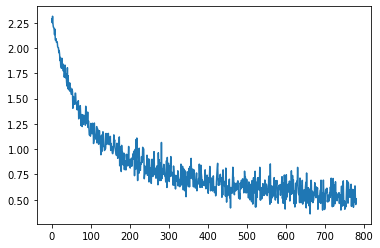

In [19]:
plt.plot(losses); # loss가 왔다갔다하며, 제대로 학습이 되지 않는 것을 볼 수 있음. 이유는 regularization이 너무 강해서(또는 약해서), 학습이 방해가 되는것.

In [20]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
#         self.lin1 = nn.Linear(784, 50, bias=True) # 50 neuron을 가지는 Hidden layer 추가.
#         self.lin2 = nn.Linear(50, 10, bias=True)
        self.lin1 = nn.Linear(784, 100, bias=True) # 100 neuron을 가지는 Hidden layer 추가. 여전히 잘됨. loss의 증가폭이 약간 커짐.
        self.lin2 = nn.Linear(100, 10, bias=True)


    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x) # activation func은 ReLU.
        return self.lin2(x)

In [21]:
model = Mnist_NN().cuda()

In [22]:
losses = [update(x,y,lr) for x,y in data.train_dl]

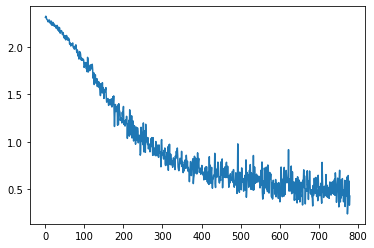

In [23]:
plt.plot(losses);

In [24]:
model = Mnist_NN().cuda()

In [25]:
def update(x,y,lr):
    #opt = optim.Adam(model.parameters(), lr) # adam optimizer 설정.
    opt = optim.SGD(model.parameters(), lr) # loss가 linear하게 떨어지는 신기한 풍경(?)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [26]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

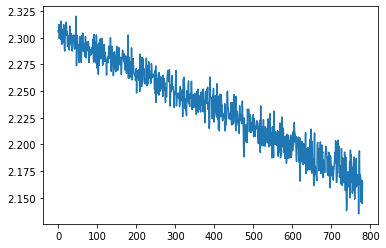

In [27]:
plt.plot(losses);

In [28]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

In [29]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


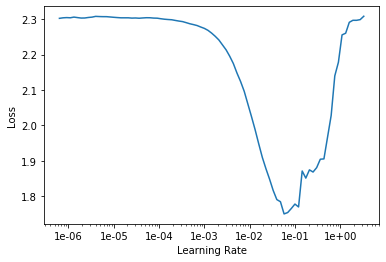

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(3, 1e-2) # 3 epoch 학습시 acc는 adam보다 SGD가 더 올라감.

epoch,train_loss,valid_loss,accuracy,time
0,0.224587,0.169250,0.951600,00:02
1,0.121434,0.103921,0.969900,00:02
2,0.043930,0.080304,0.977800,00:02


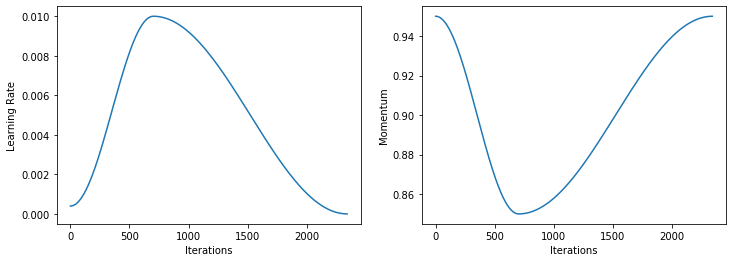

In [32]:
learn.recorder.plot_lr(show_moms=True)

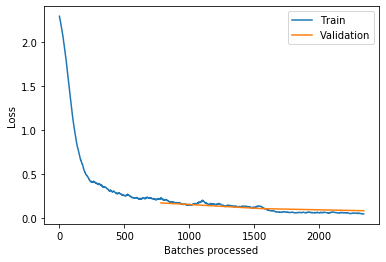

In [33]:
learn.recorder.plot_losses() # 아름다운 validation loss를 볼 수 있음.

## fin

## Comment :

- fastai + pytorch를 통해 굉장히 쉽게 NN을 밑바닥부터(?) 구현할 수 있다.

- MNIST 같은 쉬운 예제를 통해 실습하였기 때문에 아름다운 accuracy와 loss를 볼 수 있지만, CIFAR-10으로만 바꾸더라도 학습이 잘되진 않을 것 같다.

- 직접 모델을 클래스를 통해 구현하는 것으로, NN의 구조나 optimizier가 하는 역할, weight decay, backprop 과정등에 대해 개념을 익히고 실습해 볼 수 있었다.

- 진정한 구현 공부를 하려면(?) numpy를 이용하여 하나하나 작성해보면 도움이 더 많이 된다.

- fastai를 통해 손쉽게 optimizerd와 hyperparameter에 따른 성능 변화를 볼 수 있었는데, adam optimizer보다 SGD optimizer가 쉽게 학습이 잘되는 것이 가장 놀라웠다.